# Dimensionality Reduction

## What is it?

Dimensionality reduction is the process of simplifying data by reducing the number of input variables, of features, in a data set while retaining as much important information as possible. For example, say 1000 ingredients go into a recipe. You can reduce the number of variables/ingredients by grouping them into types of food. We're taking high-dimensional data and formatting it in a lower dimensional representation which captures the important character of the data.  
![](./dim_red.png)

## Why are we doing it?

**Advantages**:  
1. *Faster Computation*: With fewer features machine learning algorithms can process data more quickly. This results in faster model training and testing which is particularly useful when working with large data sets.  
2. *Better Visualization*: As we saw in the earlier figure reducing dimensions makes it easier to visualize data and reveal hidden patterns.  
3. *Prevent Overfitting*: With few features models are less likely to memorize the training data and overfit. This helps the model generalize better to new, unseen data improve its ability to make accurate predictions.

**Disadvantages**:  
1. *Data Loss & Reduced Accuracy*: Some important information may be lost during dimensionality reduction and affect model performance.  
2. *Choosing the Right Components*: Deciding how many dimensions to keep is difficult as keeping too few may lose valuable information while keeping too many can led to overfitting.

## Principal Component Analysis

One of the reasons that PCA is so common is that it is very easy to understand graphically. principal component analysis finds a rotation in the space of the data such that successively decreasing axes of variation are aligned with the axis of the coordinate system.

**Steps:**  
1. *Look for directions of maximum variation.*  
PCA finds the directions (lines or axes) in your data where the points spread out the most. Example: If you plot height vs. weight, the data might stretch diagonally. That diagonal is the first principal component.  
2. *Create new axes (principal components)*.  
These new axes are combinations of the original features, but chosen so they capture the most variation:  
1st principal component: the direction with the most variation.  
2nd principal component: the next-most variation, but at a right angle to the first.  
3. *Reduce dimensions.*  
   Instead of keeping all original features, you keep only the first few principal components. This way you shrink the data (say from 100 dimensions down to 2 or 3) but still keep most of the meaningful structure.

### Example of PCA - Simple Oscillator
See the data set below.

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


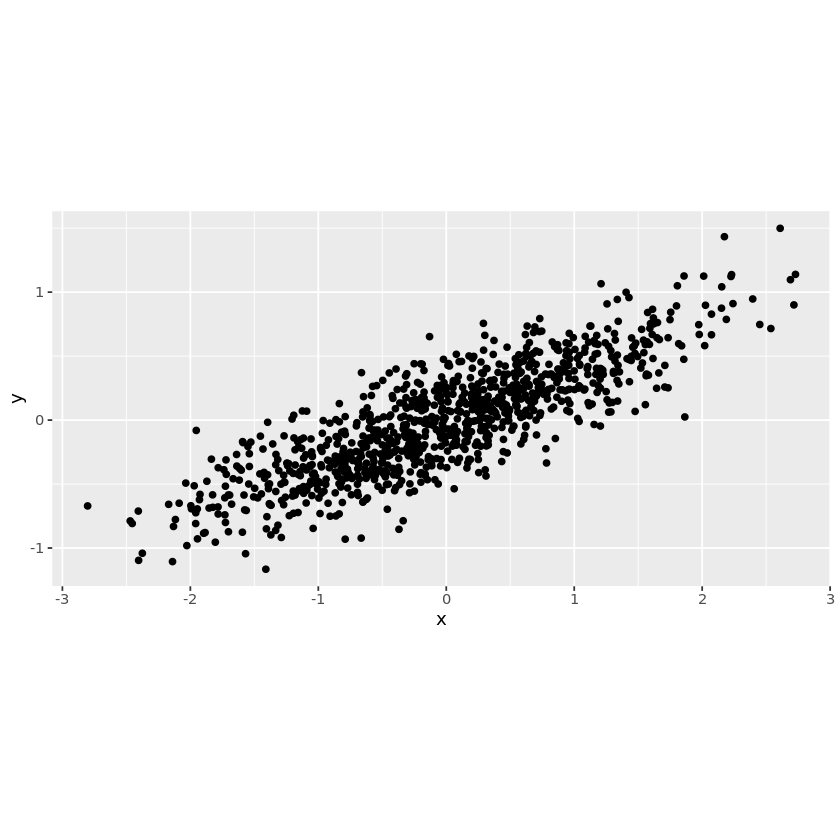

In [1]:
library(tidyverse)
d <- tibble(x=rnorm(1000,0,1),y=rnorm(1000,0,0.25)) %>%
    mutate(x=cos(pi/8)*x - sin(pi/8)*y,
           y=sin(pi/8)*x + cos(pi/8)*y);
print(ggplot(d, aes(x,y)) + geom_point() + coord_fixed());

It has two primary axes of variation.

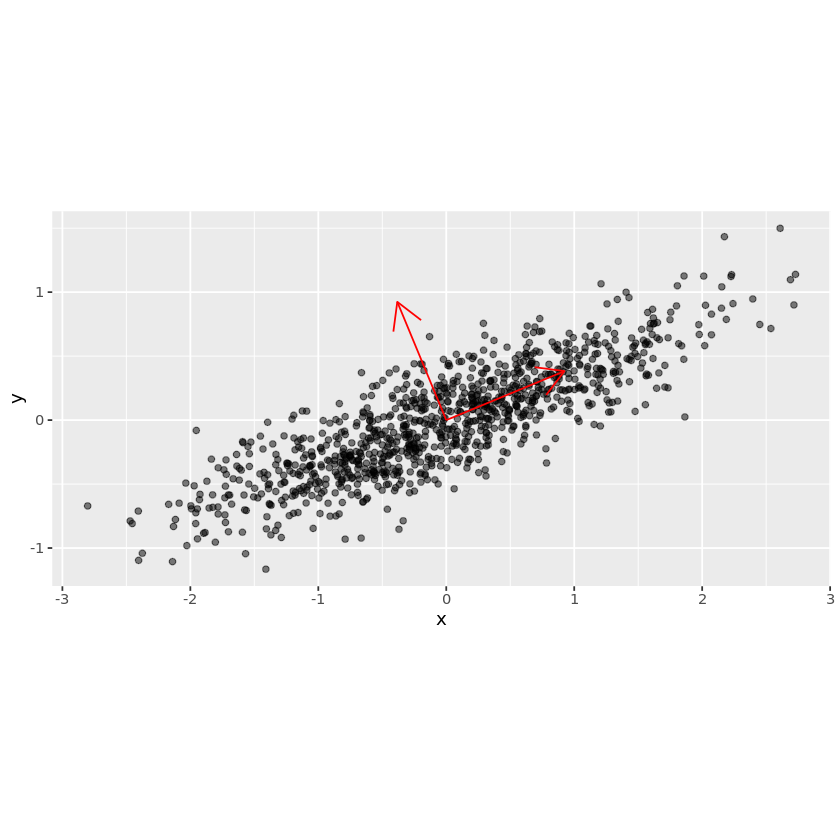

In [2]:
arrow_data <- tibble(x=c(0,0),y=c(0,0),
                     xend=c(cos(pi/8),
                            cos(pi/8 + pi/2)*1.0),
                     yend=c(sin(pi/8),
                            sin(pi/8 + pi/2)*1.0));
p <- ggplot(d, aes(x,y)) +
    geom_point(alpha=0.5) + 
    geom_segment(data=arrow_data,aes(x=x,y=y,xend=xend,yend=yend),
                 color="red",
                 arrow=arrow()) +
    coord_fixed();
print(p)

Let's say we have a simple oscillator. 
- It moves back and forth along a single line (so the true system has 1 degree of freedom).
- However, the measuring device measures *x* and *y* coordinates.
- Now, we see that the instrument isn't aligned with the oscillator's motion, as the true 1D motion looks like a diagonal line on the *(x,y)* plane.
- Additionally, the measurements have random noise on both *x* and *y*.  

**Using principal component analysis we can automatically find that axis of maximal variation corresponding to the true degrees of freedom of the underlying system.** Once we have our rotated data we can throw away the unimportant axis.

See the section of code below.  
`r <- prcomp(d)` is running the PCA on the data set we created earlier. We're getting **principal component directions** (the axes along which the data varies the most), the **scores** (your data projected onto those axes), and the **standard deviations** along each component (which reflect how much variance is captured).  
`summary(r)` gives us the **proportion of variance** (how much of the total variability is explained by each component), and **cumulative proportion** adds it up to show how much total variance you’ve captured by keeping the first *k* components.

In [3]:
r <- prcomp(d); # runs PCA on d
r
summary(r); # 

Standard deviations (1, .., p=2):
[1] 1.0232608 0.2158855

Rotation (n x k) = (2 x 2):
        PC1        PC2
x 0.9324314 -0.3613470
y 0.3613470  0.9324314

Importance of components:
                          PC1     PC2
Standard deviation     1.0233 0.21589
Proportion of Variance 0.9574 0.04261
Cumulative Proportion  0.9574 1.00000

Notice a few things:
1. The *(x,y)* coordinates of PC1 and PC2 are orthogonal.
2. PC1 has the largest standard deviation and explains the most variance.

We can apply the rotation to our data by hand. Recall that given a
rotation matrix $R_{ij}$ the new coordinates are just:

$$
\begin{aligned}
&x^{'} = R_{11} x + R_{12} y\\
&y^{'} = R_{21} x + R_{22} y
\end{aligned}
$$

From the code above, the rotation matrix is:
$$
R = 
\begin{pmatrix}
0.9334627 & -0.3586745 \\
0.3586745 & 0.9334627
\end{pmatrix}
$$

We can get the rotation matrix like this:

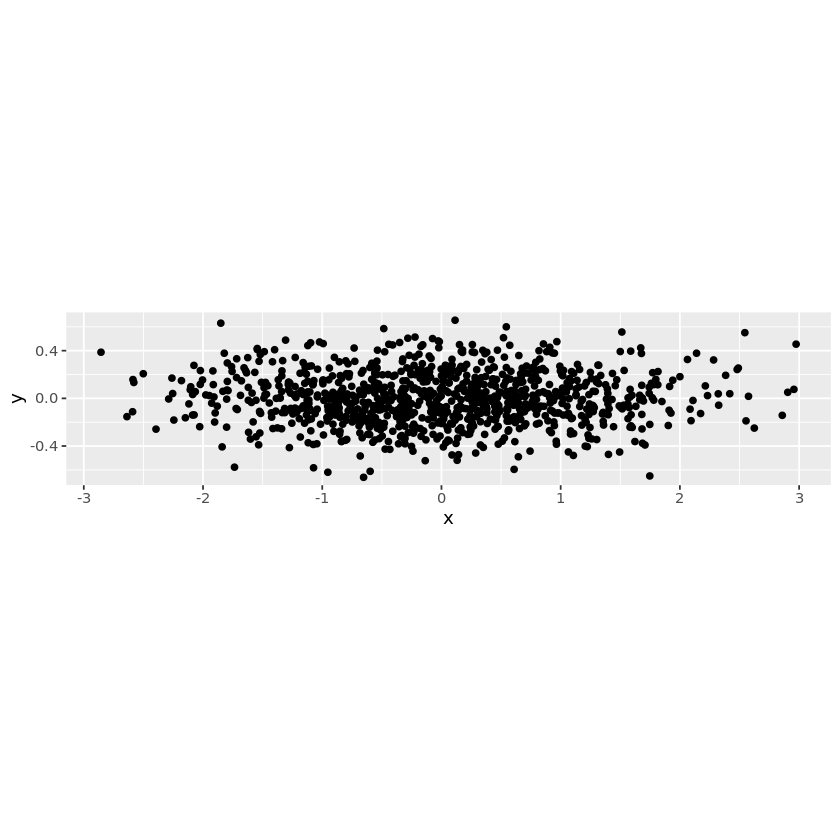

In [4]:
R <- solve(r$rotation); # r$rotation is the rotation matrix
dr <- d %>% mutate(xp = R[1,1]*x + R[1,2]*y,
                   yp = R[2,1]*x + R[2,2]*y) %>%
    select(-x,-y) %>% rename(x=xp, y=yp);

print(ggplot(dr,aes(x,y)) + geom_point() + coord_fixed());

### Example of PCA - Voltage Traces

Importing code from the first example in the lecture (which I didn't include in the beginning for simplicity).  
  
*Adding `ggmd()` and `mdpre()`.*

In [5]:
if (!exists("mdpre")) mdpre <- function(x) { print(x) }
if (!exists("ggmd"))  ggmd  <- function(p) { print(p) }

*Defines a FitzHugh-Nagumo type dynamical system and a function to generate a time-dependent input current with linear interpolation.*  
(Outside of the scope of this course!)

In [6]:
library(deSolve)

fhng <- function(current){
  function(t, y, p){
    V <- y[[1]]; R <- y[[2]];
    list(c(
      10*(V - V*V*V - 2*R + current(t)),
      0.1*(-R + 1.25*V + 1.5)
    ))
  }
}

make_current <- function(values, t_max){
  n <- length(values)
  function(t){
    if (t <= 0) {
      values[1]
    } else if (t >= n) {
      values[n]
    } else {
      nt <- n*t/t_max + 1
      i_low <- max(1, floor(nt))
      i_high <- min(n, ceiling(nt))
      interp <- 1 - (nt - i_low)
      values[i_low]*interp + values[i_high]*(1 - interp)
    }
  }
}

*Generate a smoothed random stimulus by repeatedly averaging each value with its neighbors and then plots it as a line graph.*

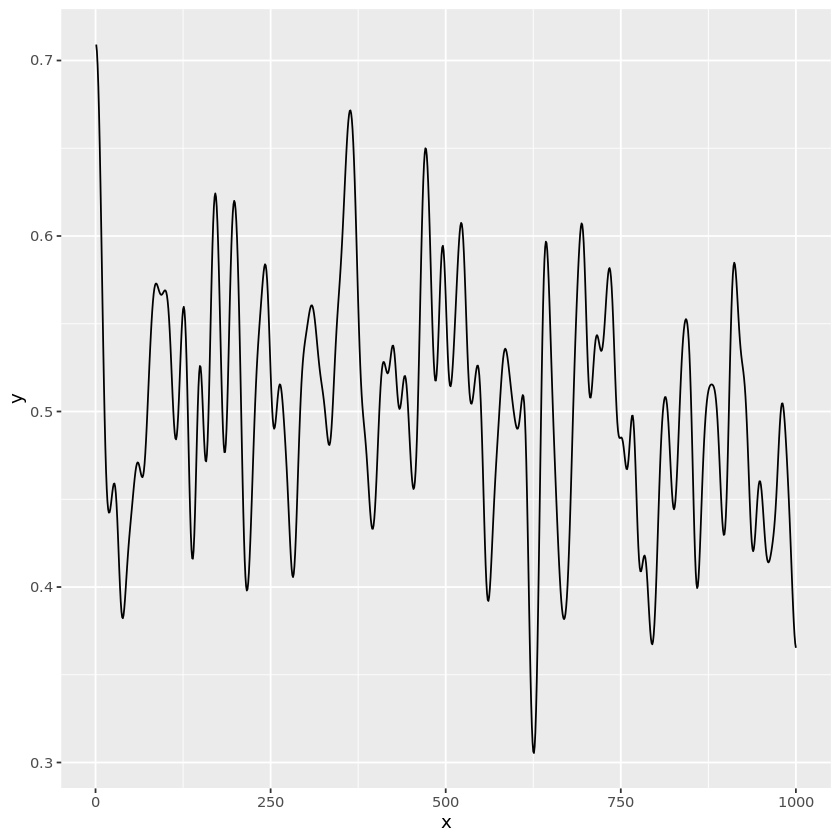

In [7]:
library(tidyverse);
dumbsmooth1 <- function(a){
    n <- length(a);
    r <- c(a[2:n],a[n]);
    l <- c(a[1], a[1:(n-1)]);
    (a + l + r)/3;
}
dumbsmooth <- function(a, n){
    for(i in seq(n)){
        a <- dumbsmooth1(a);
    }
    a
}
stimulus <- runif(1000);
stimulus <- dumbsmooth(stimulus,50);
ggmd(ggplot(tibble(x=seq(length(stimulus)), y=stimulus),aes(x,y)) + geom_line());

This code creates a time-varying input from a smoothed stimulus, simulates the FitzHugh-Nagumo model over time with that input, and plots the resulting voltage variable.

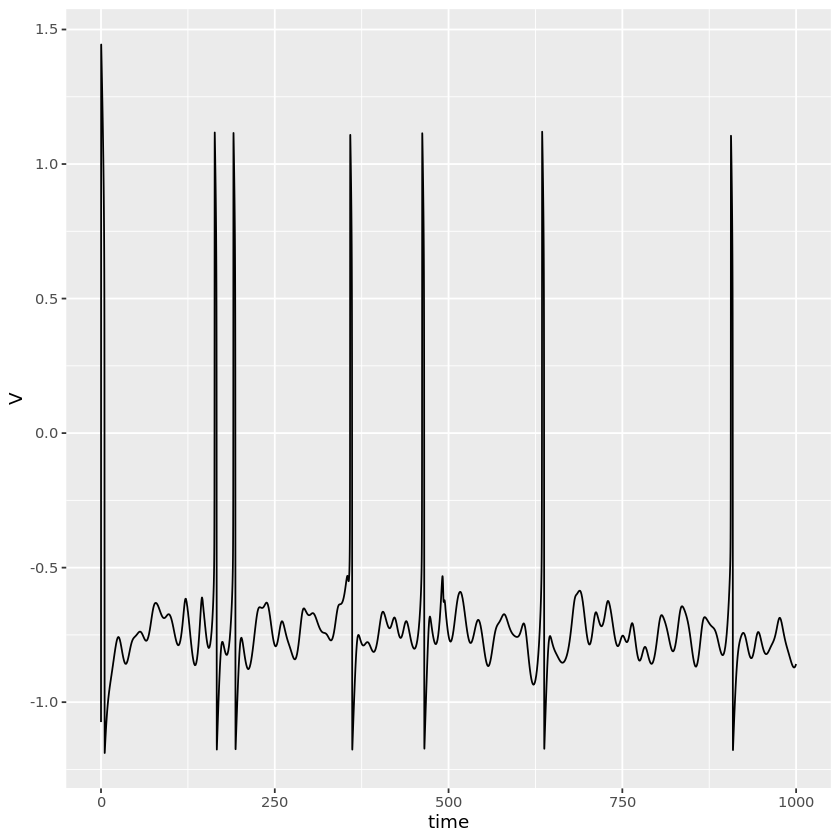

In [8]:
cc <- make_current(0.25 + stimulus*2.5, 1000)
f <- fhng(current = cc)
ic <- c(-1.07386247, 0.1642691)
r <- ode(ic, times = seq(from = 0, to = 1000, length.out = 10000), func = f) %>%
  as.matrix() %>%
  as_tibble() %>% rename(V = `1`, R = `2`) %>%
  mutate(across(everything(), as.numeric))
ggmd(ggplot(r, aes(time, V)) + geom_line())

*Runs 200 FitzHugh-Nagumo simulations with noisy inputs, saves the results, and plots the voltage for the first 10 trials.*  
Note: The lecture notes had us run 1500 trials, but that takes forever to run!

Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 10
Trial 11
Trial 12
Trial 13
Trial 14
Trial 15
Trial 16
Trial 17
Trial 18
Trial 19
Trial 20
Trial 21
Trial 22
Trial 23
Trial 24
Trial 25
Trial 26
Trial 27
Trial 28
Trial 29
Trial 30
Trial 31
Trial 32
Trial 33
Trial 34
Trial 35
Trial 36
Trial 37
Trial 38
Trial 39
Trial 40
Trial 41
Trial 42
Trial 43
Trial 44
Trial 45
Trial 46
Trial 47
Trial 48
Trial 49
Trial 50
Trial 51
Trial 52
Trial 53
Trial 54
Trial 55
Trial 56
Trial 57
Trial 58
Trial 59
Trial 60
Trial 61
Trial 62
Trial 63
Trial 64
Trial 65
Trial 66
Trial 67
Trial 68
Trial 69
Trial 70
Trial 71
Trial 72
Trial 73
Trial 74
Trial 75
Trial 76
Trial 77
Trial 78
Trial 79
Trial 80
Trial 81
Trial 82
Trial 83
Trial 84
Trial 85
Trial 86
Trial 87
Trial 88
Trial 89
Trial 90
Trial 91
Trial 92
Trial 93
Trial 94
Trial 95
Trial 96
Trial 97
Trial 98
Trial 99
Trial 100
Trial 101
Trial 102
Trial 103
Trial 104
Trial 105
Trial 106
Trial 107
Trial 108
Trial 109
Trial 110
Trial 11

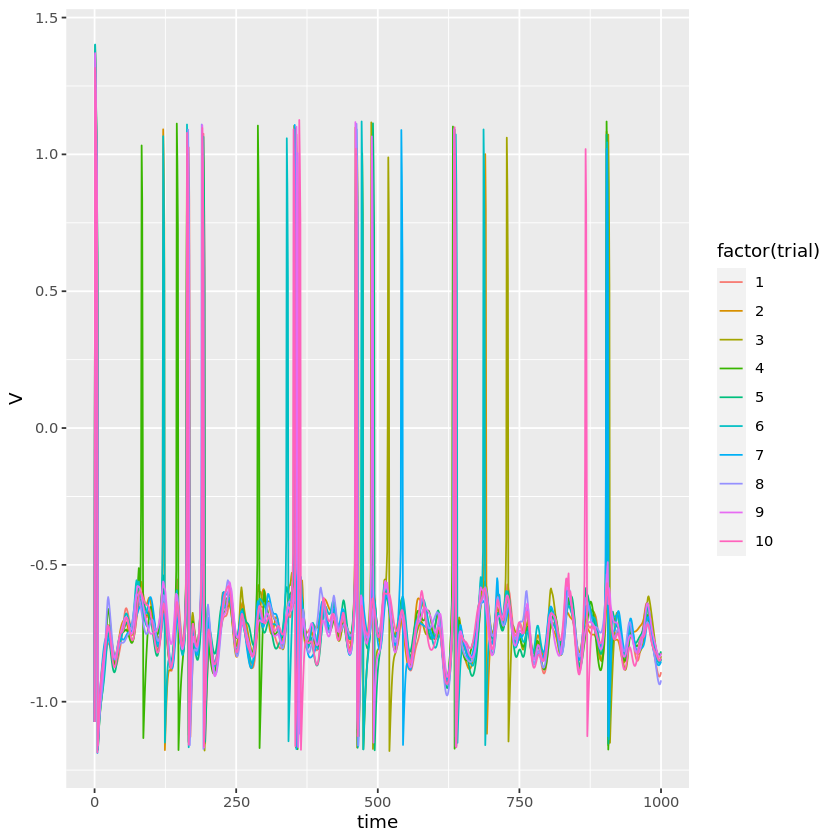

In [9]:
n_trials <- 200

data <- do.call(rbind, Map(function(trial) {
  cc <- make_current(
    0.27 + stimulus*2.5 + dumbsmooth(rnorm(length(stimulus)) * 0.3, 50),
    1000
  )
  f <- fhng(current = cc)
  ic <- c(-1.07386247, 0.1642691)
  ode(ic, times = seq(0, 1000, length.out = 1000), func = f) %>%
    as.matrix() %>%
    as_tibble() %>%
    rename(V = `1`, R = `2`) %>%
    mutate(across(everything(), as.numeric),
           trial = trial)
}, seq_len(n_trials)))

ggmd(ggplot(data %>% filter(trial <= 10), aes(time, V)) +
  geom_line(aes(color = factor(trial))))

Now that we have our data, we need to widen our dataset and turn it into a matrix for PCA.

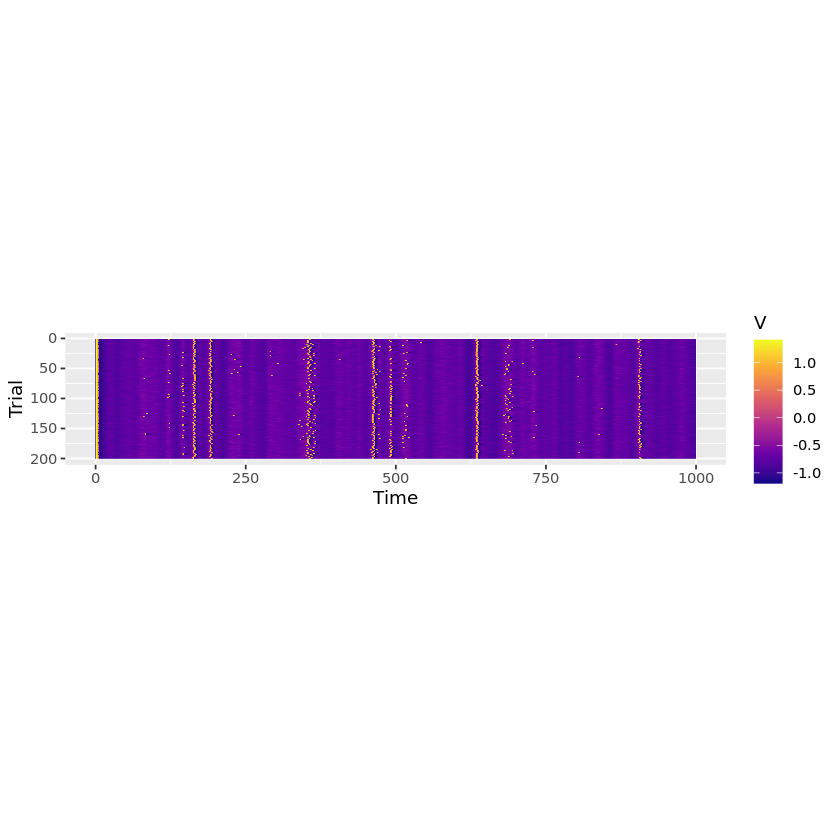

In [10]:
voltages <- pivot_wider(data %>%
                       arrange(time),
                       id_cols="trial",
                       names_from="time",
                       values_from=V,
                       names_sort=FALSE) %>%
    select(-trial) %>% as.matrix();
## Convert matrix to long-form tibble and plot heatmap
vol_df <- as_tibble(voltages) %>%
  mutate(row = row_number()) %>%
  pivot_longer(cols = -row, names_to = "col", values_to = "value") %>%
  mutate(col = suppressWarnings(as.numeric(gsub("^[^0-9]*", "", col))))
ggmd(ggplot(vol_df, aes(x = col, y = row, fill = value)) +
       geom_raster() +
       scale_y_reverse() +
       coord_fixed() +
       scale_fill_viridis_c(option = "C") +
       labs(x = "Time", y = "Trial", fill = "V"));

Importance of components:
                           PC1     PC2     PC3     PC4     PC5     PC6     PC7
Standard deviation     1.57478 1.53570 1.40052 1.33796 1.29162 1.26649 1.21296
Proportion of Variance 0.06707 0.06378 0.05305 0.04842 0.04512 0.04338 0.03979
Cumulative Proportion  0.06707 0.13085 0.18390 0.23232 0.27744 0.32082 0.36061
                           PC8     PC9   PC10    PC11    PC12   PC13    PC14
Standard deviation     1.13894 1.11658 1.0929 1.01374 0.98578 0.9710 0.94533
Proportion of Variance 0.03508 0.03372 0.0323 0.02779 0.02628 0.0255 0.02417
Cumulative Proportion  0.39569 0.42941 0.4617 0.48951 0.51579 0.5413 0.56546
                         PC15   PC16    PC17    PC18    PC19    PC20    PC21
Standard deviation     0.9102 0.8642 0.81901 0.78775 0.76157 0.71139 0.69010
Proportion of Variance 0.0224 0.0202 0.01814 0.01678 0.01569 0.01369 0.01288
Cumulative Proportion  0.5879 0.6081 0.62621 0.64299 0.65868 0.67236 0.68524
                          PC22    PC23    

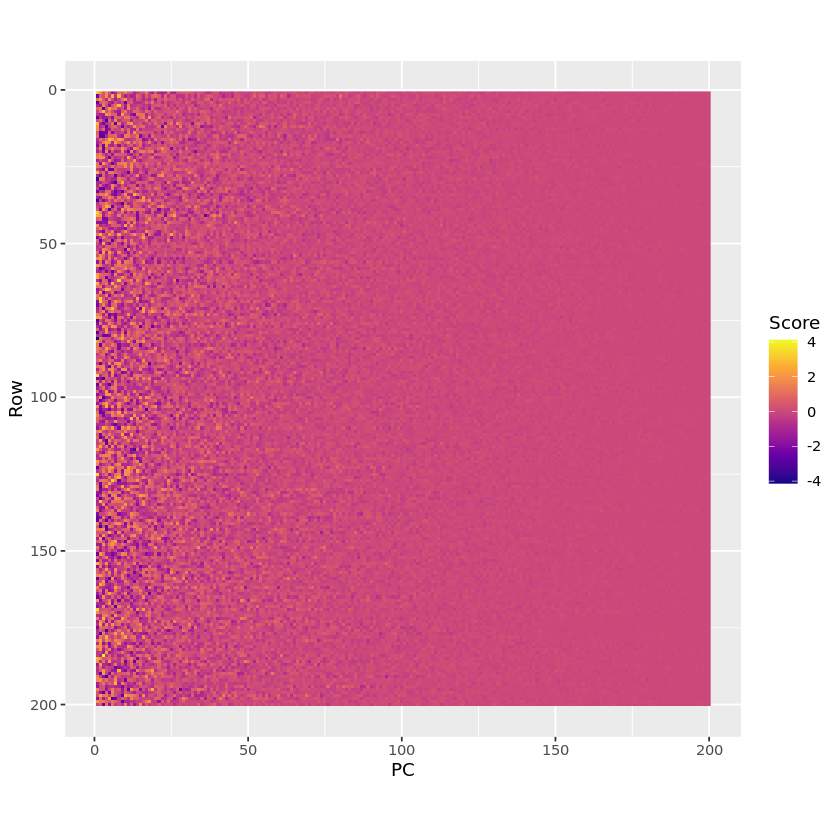

In [11]:
results <- prcomp(voltages);
## Heatmap of rotated data (scores)
rx <- results$x
ggmd(
  ggplot() +
    geom_raster(aes(
      x = rep(1:ncol(rx), each = nrow(rx)),
      y = rep(nrow(rx):1, times = ncol(rx)),
      fill = as.vector(rx)
    )) +
    scale_y_reverse() +
    coord_fixed() +
    scale_fill_viridis_c(option = "C") +
    labs(x = "PC", y = "Row", fill = "Score")
)
summary(results);

We expect that as we choose larger and larger dimensions by index, the variation in those components is smaller and smaller. **One thing we can do is just chop off all but a few components.**

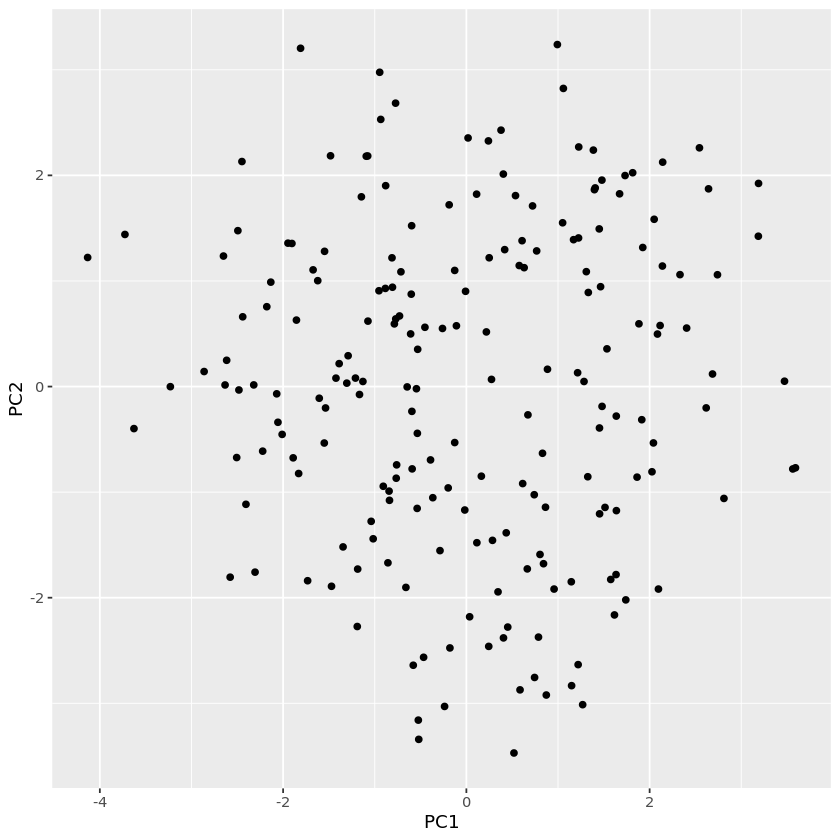

In [12]:
ggmd(ggplot(results$x %>% as_tibble() %>% select(PC1, PC2), aes(PC1, PC2)) +
    geom_point());

There look like **there might be clusters here.** With very high dimensional data sets it's hard to appreciate what these low dimensional projections might mean without making additional plots.  

If we have labels on our data this would be a time to use them, but we don't have any. **Let's just count spikes.**

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


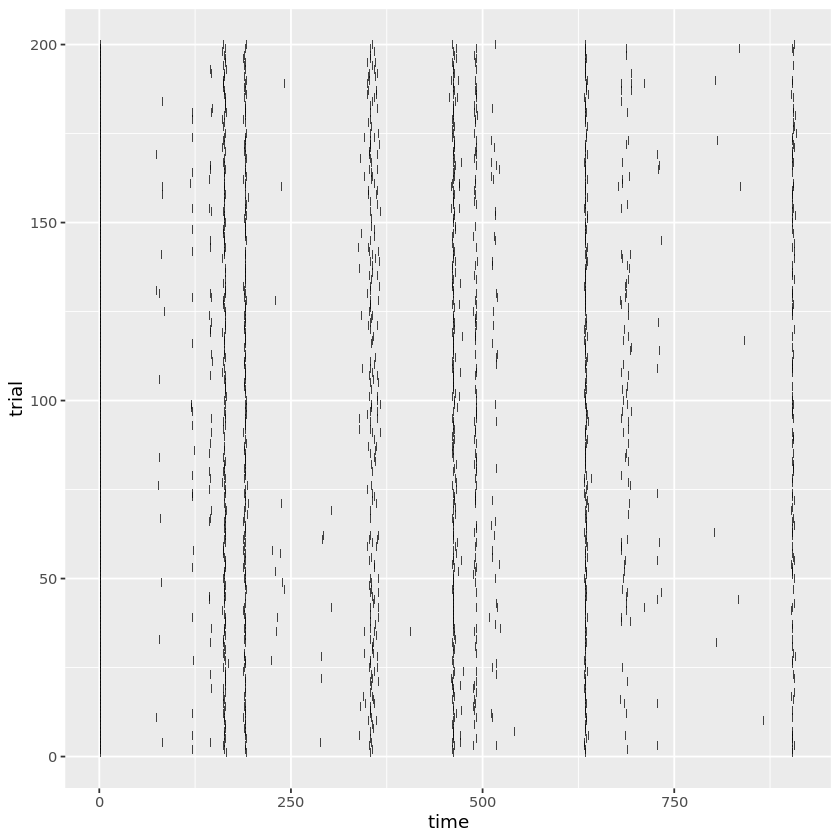

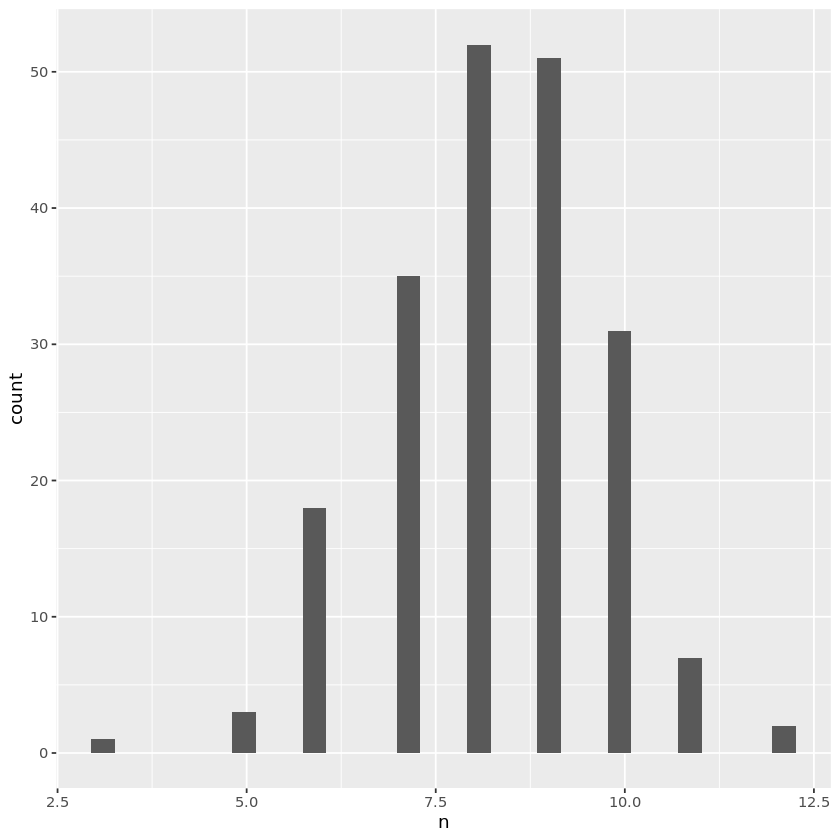

In [13]:
spikes <- data %>% group_by(trial) %>% filter(V >= 0 & lag(V) < 0) %>% ungroup();
ggmd(ggplot(spikes, aes(time, trial)) + geom_point(shape="|"))

spike_counts <- spikes %>% group_by(trial) %>% tally() %>%
    arrange(trial) %>% mutate(tritile=ntile(n, 3))
ggmd(ggplot(spike_counts, aes(n)) + geom_histogram())

And now we can **label our projection by spike count**, which may reveal something.

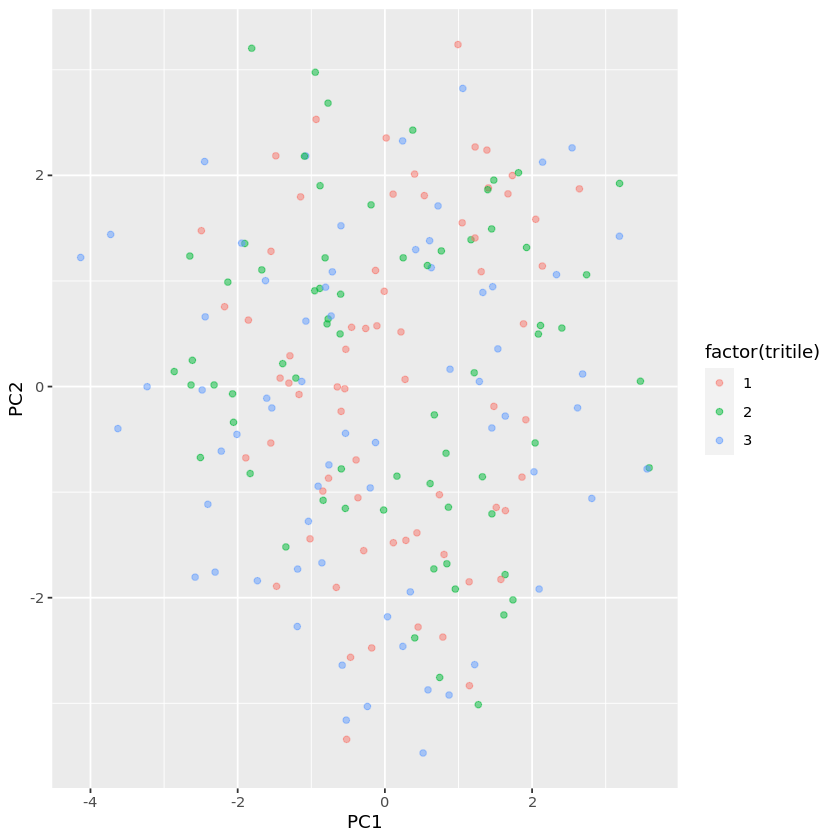

In [14]:
data_2d <- results$x %>% as_tibble() %>% select(PC1, PC2);
data_2d$spike_count <- spike_counts$n;
data_2d$tritile <- spike_counts$tritile;
ggmd(ggplot(data_2d, aes(PC1,PC2)) + geom_point(aes(color=factor(tritile)),alpha=0.5));

Another method we might try is subdividing the 2d data and plotting the voltage traces (this works for this example because the voltage traces are intelligible as time series).

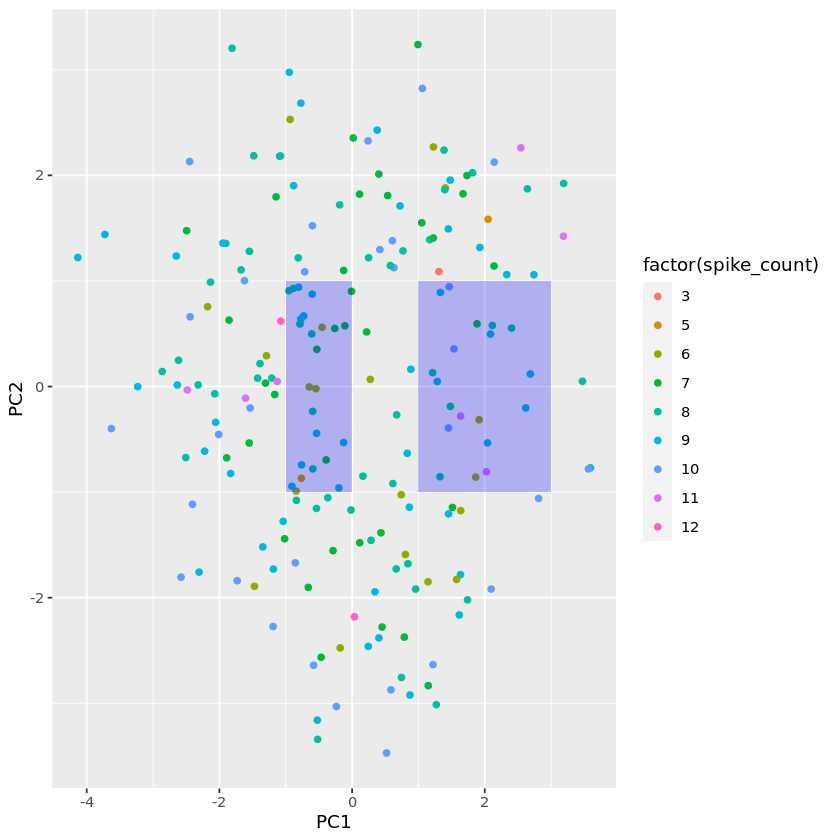

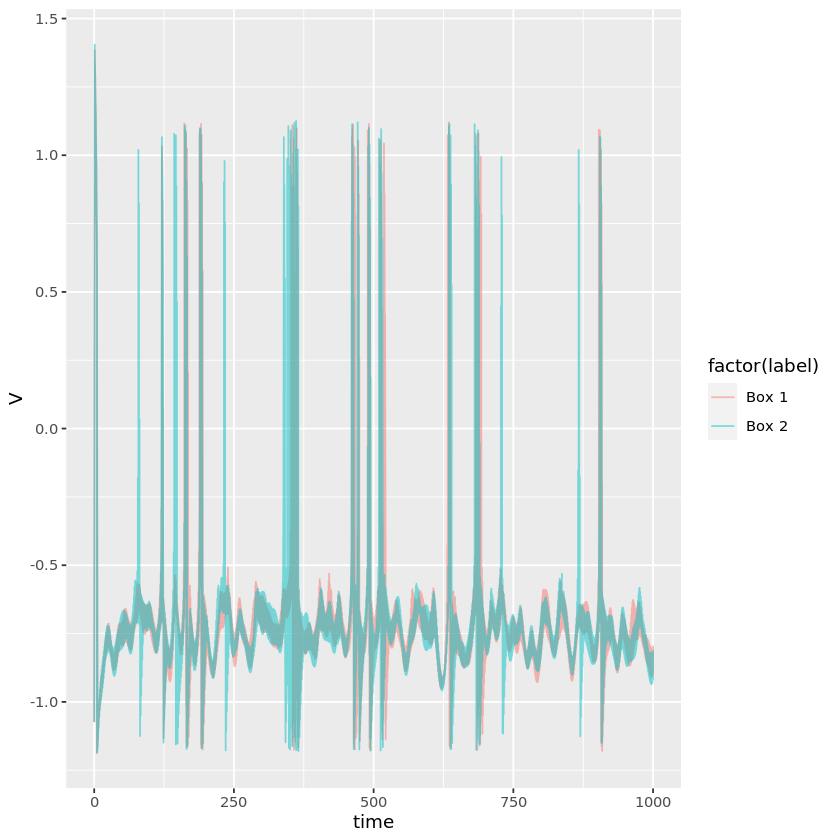

In [15]:
ggmd(ggplot(data_2d, aes(PC1,PC2)) + geom_point(aes(color=factor(spike_count))) +
    geom_rect(inherit.aes = FALSE, data=tibble(
                  xmin=c(-1, 1),
                  ymin=c(-1,-1),
                  xmax=c( 0, 3),
                  ymax=c( 1, 1)),
              mapping=aes(xmin=xmin, ymin=ymin,
                          xmax=xmax, ymax=ymax),
              fill="blue",
              alpha=0.25));

data_2d$trial <- seq(nrow(data_2d));
s1 <- data_2d %>% filter(PC1 >= -1 & PC1 <= 0 &
                         PC2 >= -1 & PC2 <= 1) %>% mutate(label="Box 1");
s2 <- data_2d %>% filter(PC1 >= 1 & PC1 <= 3 &
                         PC2 >= -1 & PC2 <= 1) %>% mutate(label="Box 2");

s <- rbind(s1 %>% head(10),s2 %>% head(10));

traces_ex <- data %>% inner_join(s, by="trial");

ggmd(ggplot(traces_ex,
       aes(time, V)) + geom_line(aes(color=factor(label)),alpha=0.5));

After a neuron spikes it has a brief refractory period during which it cannot spike again. Physiologically this is because the membrane is depolarized by the ion channels which open lower the voltage back down to near the resting potential.

A final thing we can do with principal components is zero the smaller ones and rotate back into the actual space of the data. This should eliminate the noisy part of the variation subject to all the interpretational difficulties associated with PCA.

Let's keep the first 100 components.

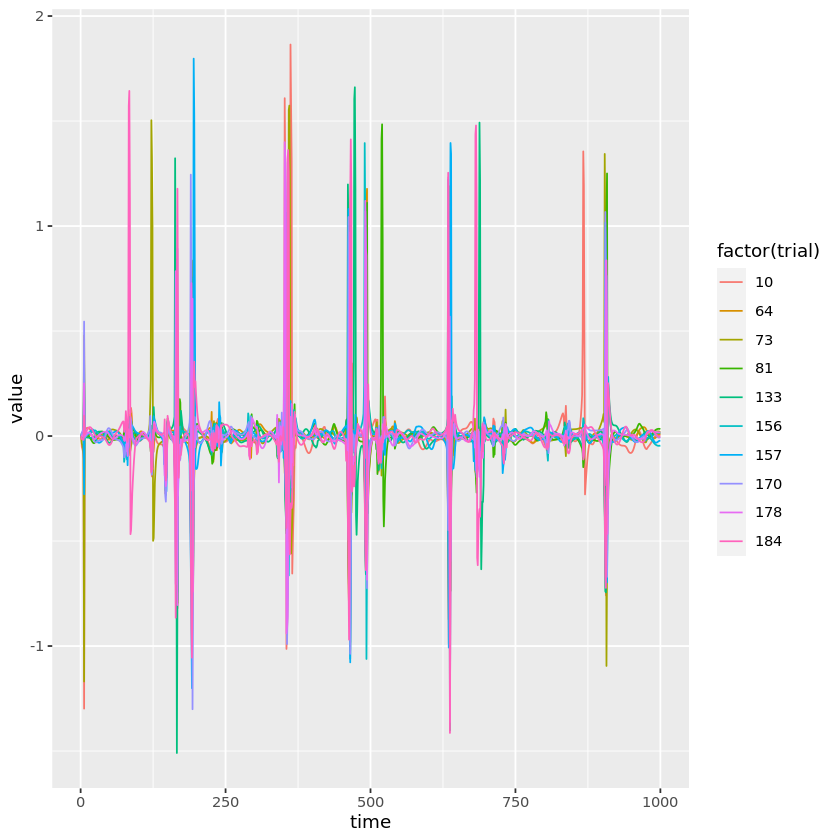

In [19]:
r <- results$rotation
rotated <- results$x

# Keep only the first 100 PCs (zero out the rest)
rotated[, 101:ncol(rotated)] <- 0

less_noisy <- do.call(rbind, Map(function(trial) {
  v <- rotated[trial, ]
  t(r %*% v)
}, 1:nrow(rotated)))   # nrow(rotated) = 200 trials

prep <- less_noisy %>%
  as_tibble() %>%
  mutate(trial = seq_len(nrow(.))) %>%
  pivot_longer(cols = -trial, names_to = "col", values_to = "value") %>%
  group_by(trial) %>%
  mutate(time = seq_len(n())) %>%
  ungroup() %>%
  filter(trial %in% sample(1:nrow(rotated), 10))

ggmd(
  ggplot(prep, aes(time, value)) +
    geom_line(aes(color = factor(trial)))
)

In this case it's not that useful of a procedure: our data really is all about those spike times and the PCs don't do a good job of capturing the results.

In summary, we:
1. Started with PCA results (rotation and scores).
2. Kept only the first 100 principal components by zeroing out the rest.
3. Each trial’s data was reconstructed by multiplying the rotation matrix with the truncated scores.
4. This produced a “less noisy” version of the signals because only the most important PCs are used.
5. The reconstructed signals were then reshaped into a long format with trial, time, and value columns.
6. Finally, we randomly picked 10 trials and plot their reconstructed signals over time.

## Scaling and Centering  
In general you should **scale and center** your data before doing a PCA. In particular, centering makes sense, since a PCA is a rotation and you usually want to rotate around the centroid of the data.  
Consider our data. To scale and center it is to apply a scale/center operation to each time point.

Warning message:
“Removed 10 rows containing missing values (`geom_line()`).”


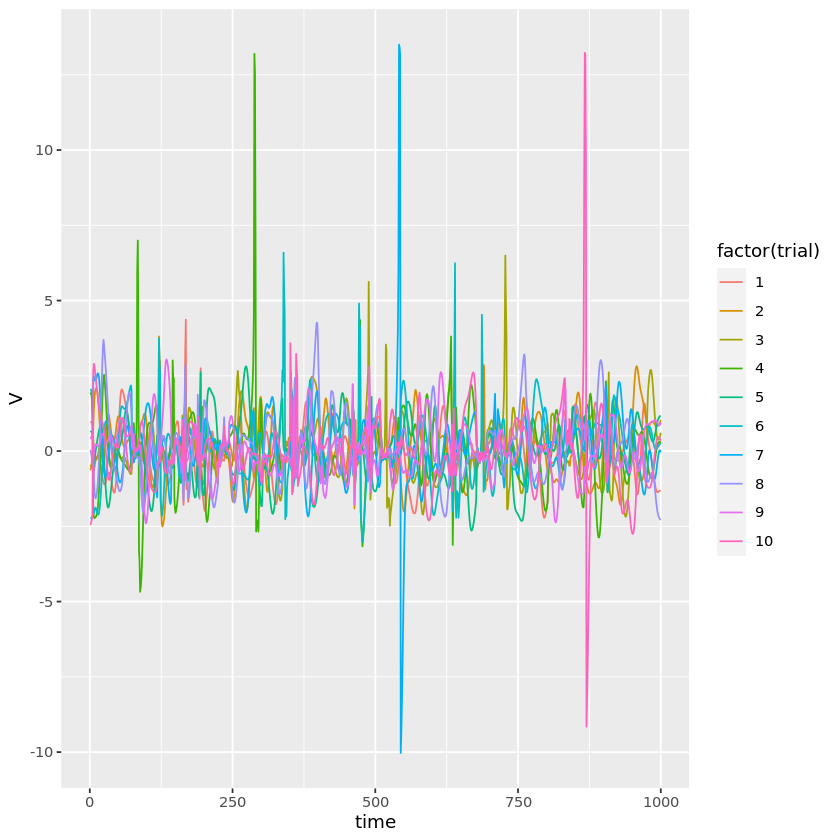

In [20]:
scaled <- data %>% group_by(time) %>% mutate(V = (V - mean(V))/sd(V));
ggmd(ggplot(scaled %>% filter(trial %in% seq(10)), aes(time, V)) + geom_line(aes(color=factor(trial))));

Scaling and centering data can reduce the impact of consistently occurring spikes, which often improves discrimination between trials, but can make visual interpretation harder. Scaling is useful when variable importance is unknown, ensuring equal variance, but if natural scales or meaningful variation exist, scaling may be unnecessary or should be done carefully. Generally, scaling and centering is the right approach in most cases.  

## When PCA Fails

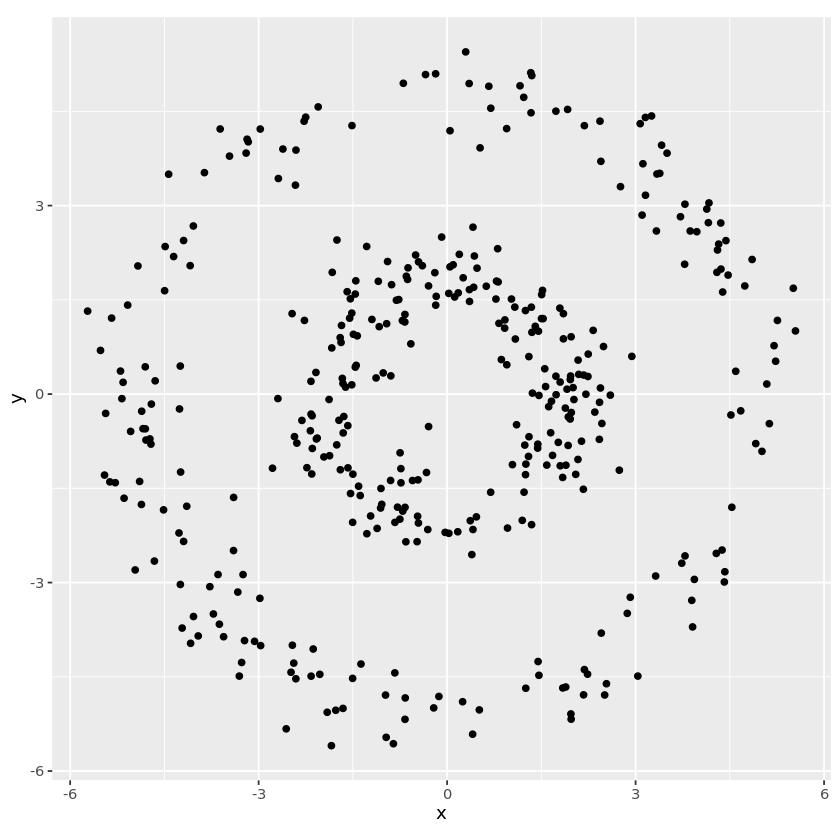

In [21]:
bad_data <- tibble(r = sample(c(2,5),size=400,replace=TRUE) + rnorm(400,0,0.4),
            theta = runif(400,0,2*pi)) %>%
    transmute(x=r*cos(theta),
              y=r*sin(theta));
ggmd(ggplot(bad_data, aes(x,y)) + geom_point() + coord_fixed());

This data set clearly only has one interesting degree of variation: the radius. But no rotation will separate these two axes. Indeed, PCA on this data set is the identity operation. You will need more sophisticated methods to deal with data like this.

Or you can apply some elbow grease: in this case, if you can manually calculate the radius then you can just throw away the angular part.  

## Vector Spaces
PCA finds a rotation which aligns axes of variation with the axes of our coordinate system. This rotation is then applied to each element of our data set individually. The only mathematical objects you can rotate are vectors.

A **vector space** is a set V along with a field F such that the following
are true:

$$
\begin{array}{l}
u, v, w \in V \\
a, b \in F \\
u + (v + w) = (u + v) + w \\
u + v = v + u \\
v + 0 = v \\
a(bv) = (ab)v \\
1v = v \\
a(u+v) = au + av \\
(a+b)v = av + bv
\end{array}
$$

Any combination of a set and a field which satisfies these axioms is a vector space. But these are quite powerful and thus restrictive. Just for instance, we must be able to add two vectors to get another. Consider a simple data set consisting of pairs of weights and heights of human beings. What does it mean to add two elements of this set?  

## Manifolds
In the case of our pairs (W,H) some operations simply don't make sense. You can understand why we might be able to sometimes get away with thinking of this data as a vector space if you consider local transformations only. In the vicinity of a particular data point a small deviation in weight or height tends to produce another physically plausible weight and height.

Thus, statistically and locally, weights and heights resemble a vector space. It's really miraculous that PCA is so generally useful given that very few data sets have any good reason to satisfy all the vector space axioms.  
  
A set which has the property that it resembles a vector space locally is called a **manifold** (speaking informally).

## Example - Simulated Voltage Traces
Consider the data below.

Rows: 225000 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (5): time, V, R, trial, label

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


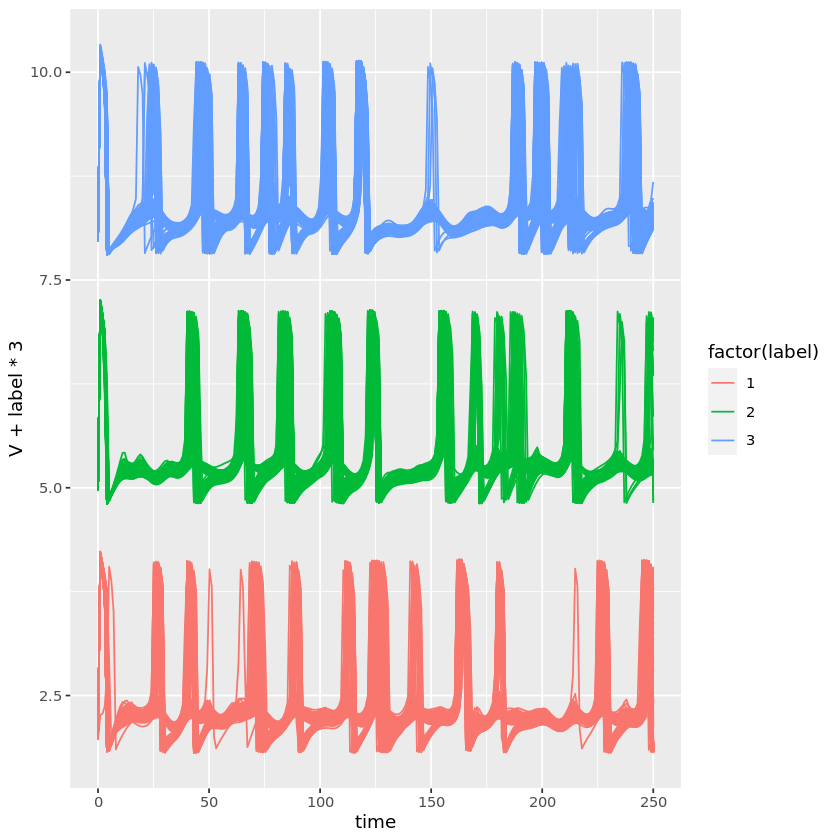

In [22]:

sim_fitznagumo <- function(t_max=250,
                           n_trials=1,
                           stimulus=c(0,0,0),
                           ic=c(-1.031463, 0.1557358)){
    data <- do.call(rbind, Map(function(trial){
        cc <- make_current(0.27+stimulus*2.5 + dumbsmooth(rnorm(length(stimulus))*0.35, 50), t_max);
        f <- fhng(current=cc);
        r <- ode(ic + 0.001*rnorm(2), times=seq(from=0,to=t_max,length.out=t_max), func=f) %>%
            as.matrix() %>%
            as_tibble() %>% rename(V=`1`, R=`2`) %>%
            mutate(across(everything(), as.numeric)) %>%
            mutate(trial=trial);
    }, seq(1:n_trials)))
    data
}
make_stim <- function(n=1000, s=50){
    stimulus <- runif(n);
    stimulus <- dumbsmooth(stimulus,s);
    stimulus
}

fn_data <- if(file.exists("sim2cache.csv")){
    read_csv("sim2cache.csv");
} else {
    ds = rbind(sim_fitznagumo(n_trials=300, stimulus=make_stim(250,s=20)) %>%
             mutate(label=1),
             sim_fitznagumo(n_trials=300, stimulus=make_stim(250,s=20)) %>%
             mutate(label=2),
             sim_fitznagumo(n_trials=300, stimulus=make_stim(250,s=20)) %>%
             mutate(label=3));
    write_csv(ds, "sim2cache.csv");
    ds
}

ggmd(ggplot(fn_data, aes(time, V + label*3)) +
    geom_line(aes(color=factor(label), group=sprintf("%d:%d",label, trial))))

The second is a more intentionally pathological case:

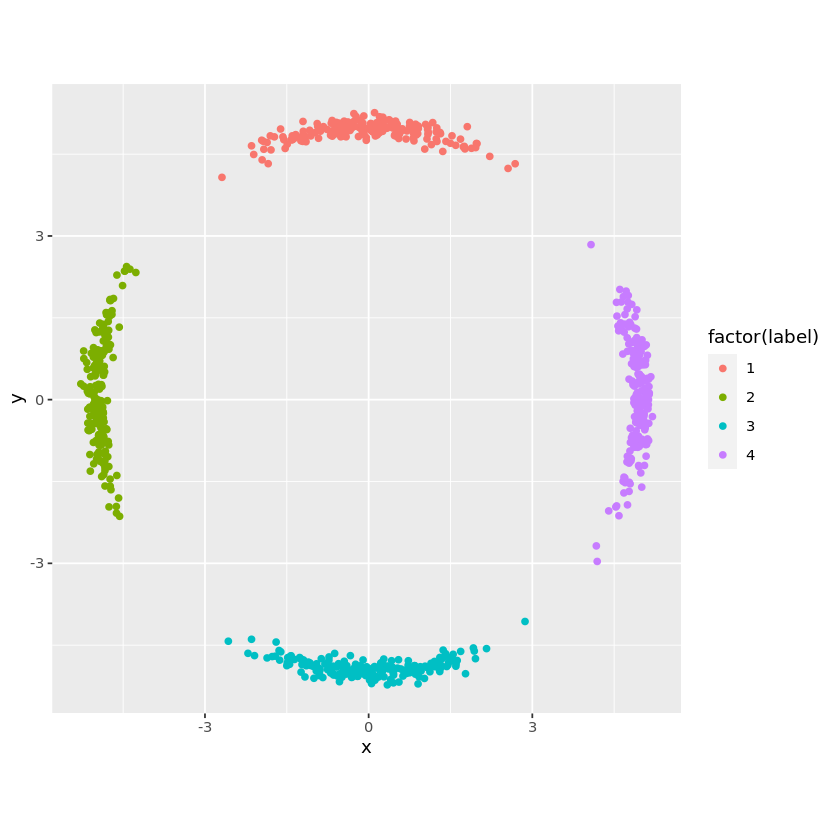

In [23]:
bad_data <- tibble(r = 5 + rnorm(800,0,0.1),
                   theta = c(rnorm(200,pi/2,0.2),
                             rnorm(200,2*pi/2, 0.2),
                             rnorm(200,3*pi/2, 0.2),
                             rnorm(200,0, 0.2))) %>%
    transmute(x=r*cos(theta),
              y=r*sin(theta),
              label=c(rep(1,200),
                      rep(2,200),
                      rep(3,200),
                      rep(4,200)));
ggmd(ggplot(bad_data, aes(x,y)) + geom_point(aes(color=factor(label))) + coord_fixed())

Our process is always the same:
1. Do a dimensionality reduction.
2. Look at the projection in 2D.

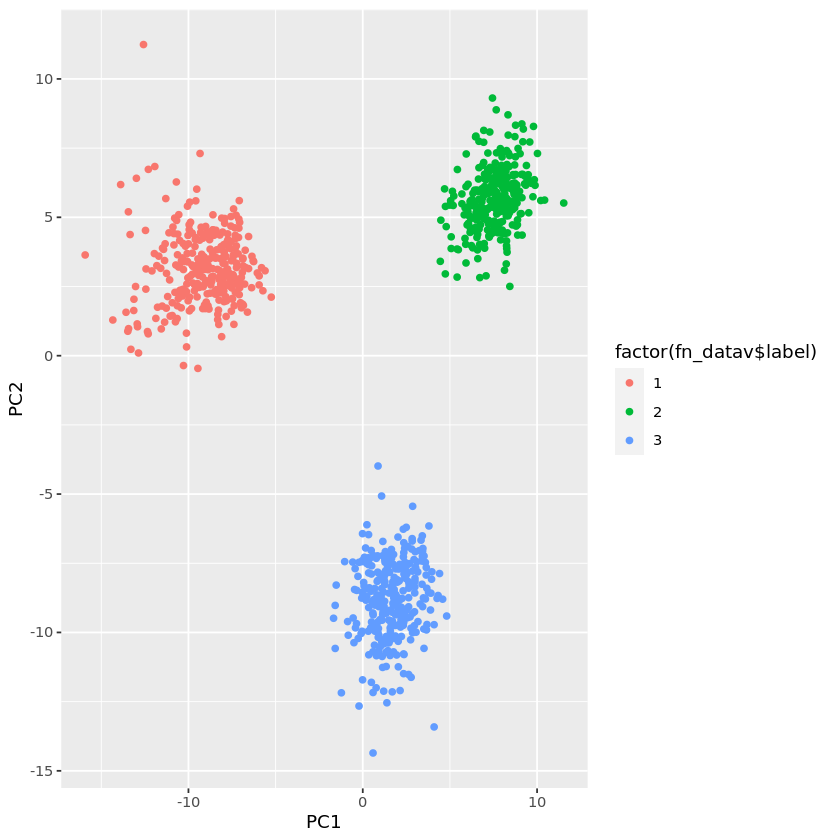

In [24]:
fn_datav <- pivot_wider(fn_data %>%
                      arrange(time) %>% filter(time>1),
                      id_cols=c("trial","label"),
                      names_from="time",
                      values_from="V",
                      names_sort=FALSE);
results <- prcomp(fn_datav %>% select(-trial,-label) %>% as.matrix(),
                  center=T, scale=T);
ggmd(ggplot(results$x %>% as_tibble(), aes(PC1,PC2)) + geom_point(aes(color=factor(fn_datav$label))))

Remarkably good!

The pathological data:

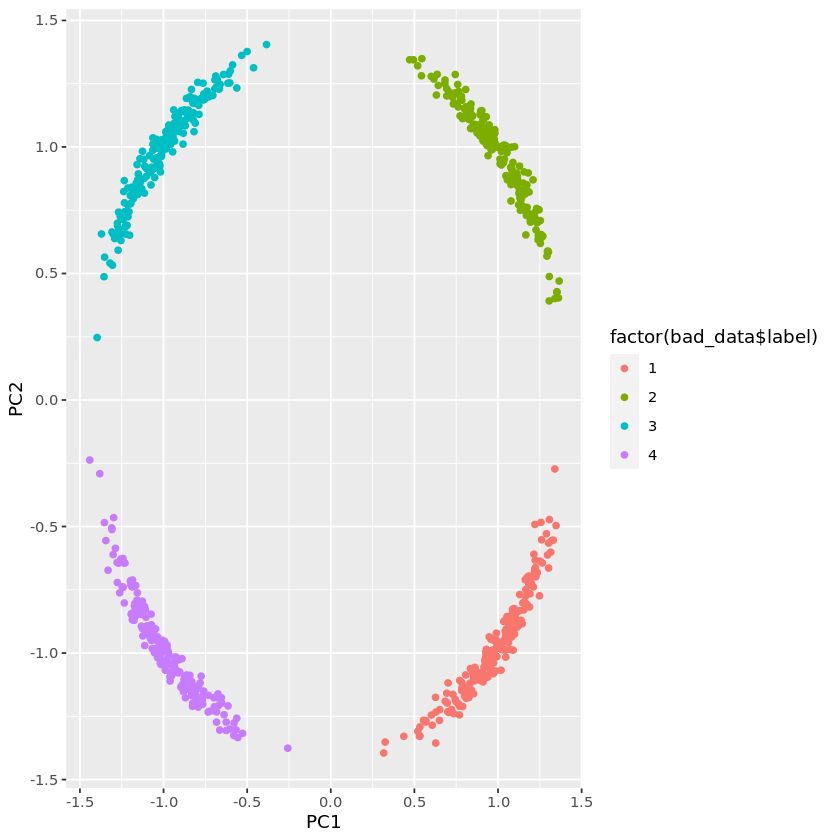

In [25]:
results <- prcomp(bad_data %>% select(x,y) %>% as.matrix(), center=T, scale=T);
ggmd(ggplot(results$x %>% as_tibble(), aes(PC1,PC2)) + geom_point(aes(color=factor(bad_data$label))))

Note that if we were to throw away the second dimension in this case and look just at the density:

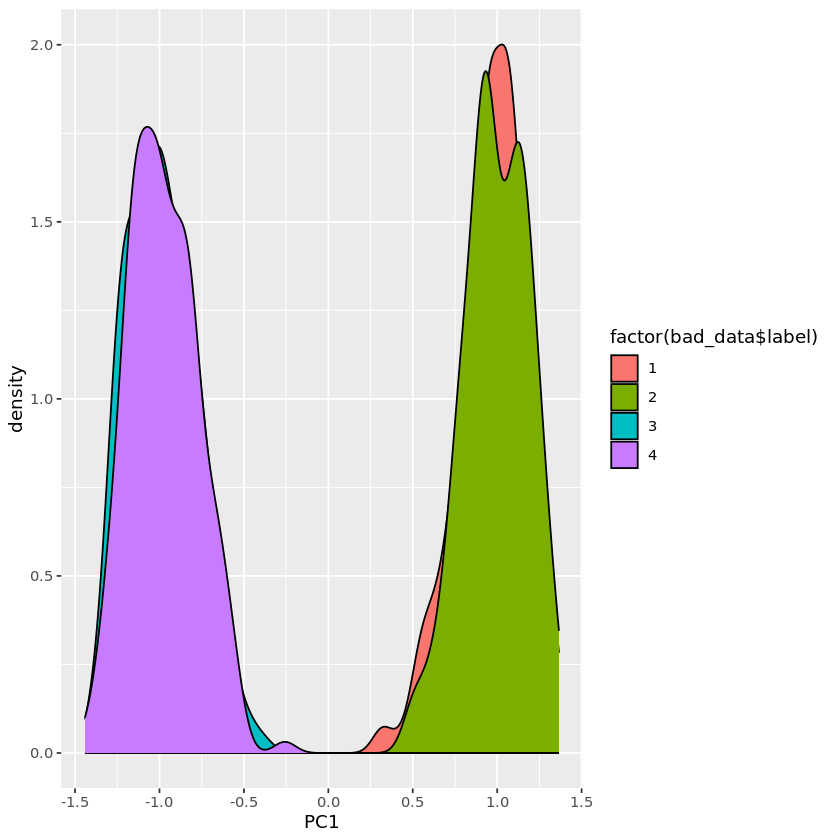

In [26]:
ggmd(ggplot(results$x %>% as_tibble(), aes(PC1)) + geom_density(aes(fill=factor(bad_data$label))))

Arguably the dimensionality reduction made this data set harder to understand!

Rather than run a million different methods, let's check out an approach emblematic of advanced approaches.

## T-SNE
T-SNE is an approach based on the idea that the important thing to model in the reduced data set is something like the **probability of two points being neighbors**. In high density areas points must be closer to one another to count as nearby, whereas in low density areas they can be further apart.  

It then seeks a map into a lower dimensional space which preserves these
probabilities without as much freedom to adjust things for density. So
it accomplishes both a dimensionality reduction and a simplification of
the distribution of points.

$$
p_{j\mid i} 
= \frac{\exp\!\left(-\tfrac{\lVert x_i - x_j \rVert^2}{2\,\sigma_i^2}\right)}{\sum_{k\ne i} \exp\!\left(-\tfrac{\lVert x_i - x_k \rVert^2}{2\,\sigma_i^2}\right)},\quad p_{ii}=0
$$

$$
p_{ij} 
= \frac{p_{j\mid i} + p_{i\mid j}}{2n},\quad i\ne j;
\qquad \sum_{i\ne j} p_{ij} = 1
$$

In the low-dimensional space with embeddings $y_i$, define a heavy-tailed Student-t kernel:

$$
q_{ij} = \frac{\left(1 + \lVert y_i - y_j \rVert^2\right)^{-1}}{\sum_{k\ne l} \left(1 + \lVert y_k - y_l \rVert^2\right)^{-1}},\quad q_{ii}=0
$$

The t-SNE objective is the Kullback–Leibler divergence between \(P\) and \(Q\):

$$
\mathcal{L}(Y) = \mathrm{KL}(P\,\Vert\,Q) 
= \sum_{i\ne j} p_{ij} \log \frac{p_{ij}}{q_{ij}}.
$$

Here, each $\sigma_i$ is chosen (via binary search) to match a user-specified perplexity.


Installing package into ‘/srv/rlibs’
(as ‘lib’ is unspecified)



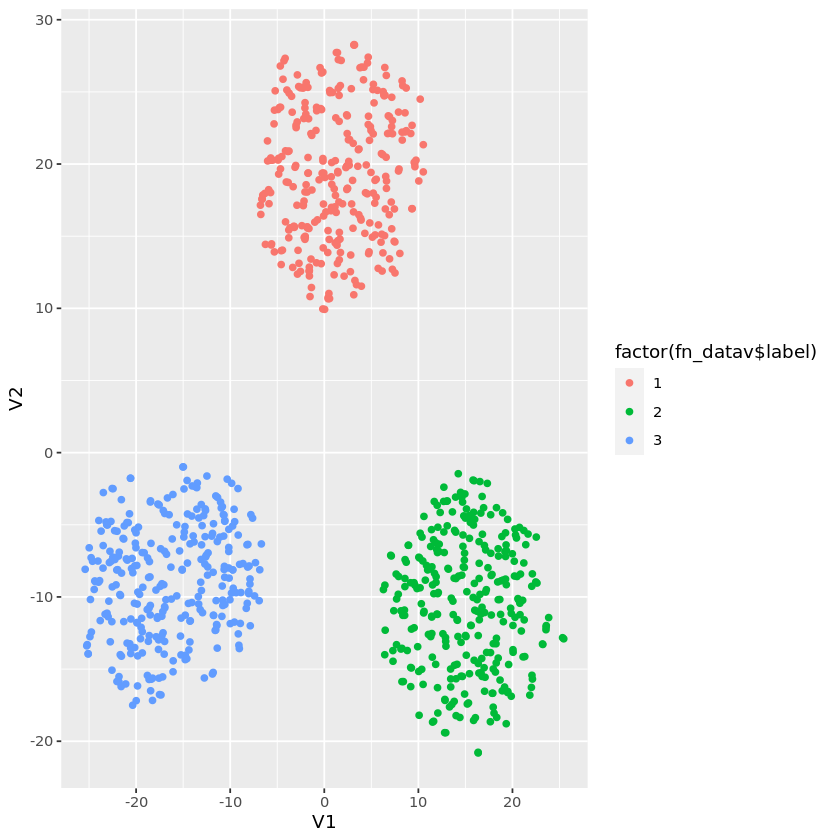

In [29]:
library(Rtsne)

X <- fn_datav %>% select(-trial, -label) %>% as.matrix()
tsne_out <- Rtsne(X, dims = 2, perplexity = 30, verbose = FALSE, check_duplicates = FALSE)
results <- as_tibble(tsne_out$Y)

ggmd(ggplot(results, aes(V1, V2)) + geom_point(aes(color = factor(fn_datav$label))))

To relate neighborhood structure before and after projection, pick a point and compare the distribution of distances from that point in the original space versus in the t-SNE embedding.

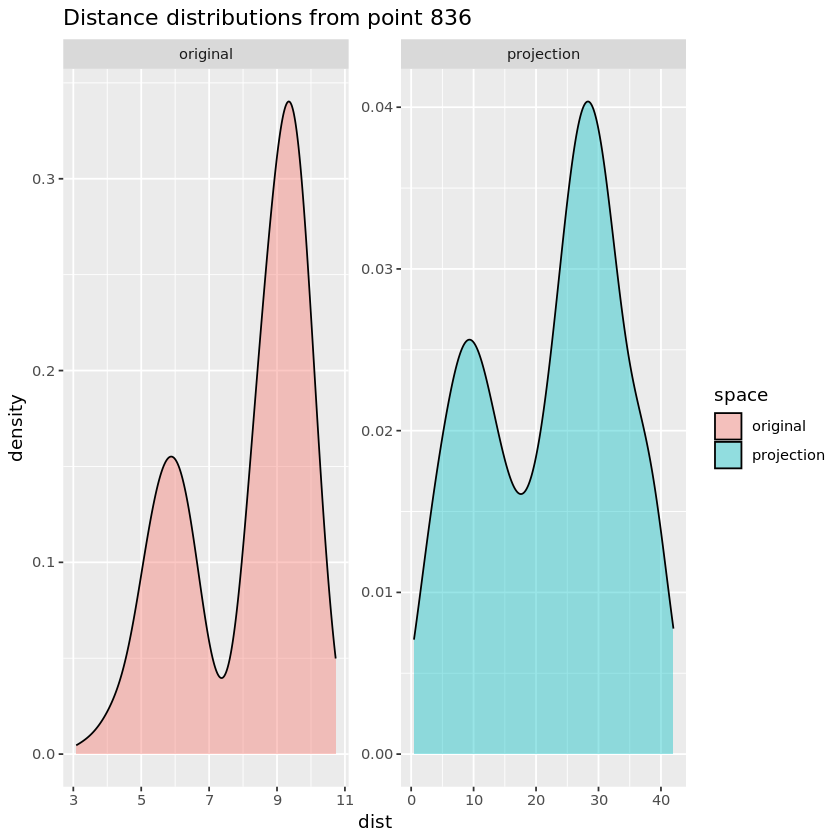

In [30]:
# Select a reference point and compute distance distributions
set.seed(1)
i <- sample(1:nrow(fn_datav), 1)
X <- fn_datav %>% select(-trial, -label) %>% as.matrix()
Y <- results %>% as.matrix()

d_high <- sqrt(rowSums((X - matrix(X[i,], nrow=nrow(X), ncol=ncol(X), byrow=TRUE))^2))
d_low  <- sqrt(rowSums((Y - matrix(Y[i,], nrow=nrow(Y), ncol=ncol(Y), byrow=TRUE))^2))

dd <- tibble(space = c(rep("original", length(d_high)-1), rep("projection", length(d_low)-1)),
             dist  = c(d_high[-i], d_low[-i]))

ggmd(ggplot(dd, aes(dist, fill = space)) +
  geom_density(alpha = 0.4) +
  facet_wrap(~space, scales = "free") +
  labs(title = sprintf("Distance distributions from point %d", i)))

The smaller data set is more illustrative:

Warning message:
“Width not defined
ℹ Set with `position_dodge(width = ...)`”


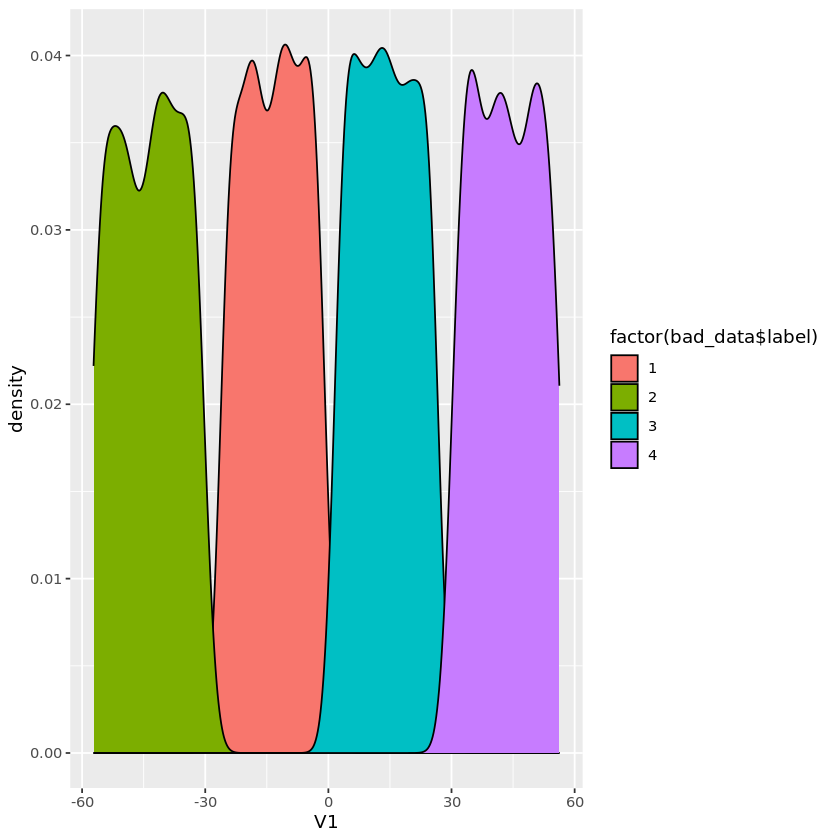

In [31]:
Y1 <- Rtsne(bad_data %>% select(x, y) %>% as.matrix(), dims = 1, perplexity = 30, verbose = FALSE, check_duplicates = FALSE)
results <- as_tibble(Y1$Y)
ggmd(ggplot(results, aes(V1)) + geom_density(aes(fill = factor(bad_data$label)), position = "dodge"))

## Important Contrasts Between TSNE and PCA
PCA produces a rotation matrix that can be applied to any new vector of the same dimensionality, assuming the original dataset is representative. This means that once principal components are identified, they can be reused on new data. For instance, neural responses measured across different individuals with similar physiology tend to show conserved patterns, so principal components derived from one set of neural recordings could theoretically be applied in later brain-computer interface applications.

In contrast, t-SNE optimizes the placement of points specifically for the training data and does not provide a way to transform new data into the same space. This makes t-SNE primarily a visualization tool rather than a method for preprocessing or generalizing to future datasets. A useful rule of thumb is to use **t-SNE for visualization** and **PCA for preprocessing or dimensionality reduction**.  

## Metric Spaces and Dimensionality Reduction
**A metric space is just a set with a distance function that satisfies a triangle inequality.** This is substantially less structure than a vector space. Many of the datasets we work with in practice have a meaningful metric but no real meaningful vector space embedding.  
  
For example, consider a dataset of names. While it makes no sense add “Smith” and “Herve”, we can still define a distance between them, such as the edit distance that measures how many changes are needed to transform one name into another. Some dimensionality reduction methods, like multidimensional scaling (MDS), can work directly with such distances. **MDS finds coordinates for each element based only on the distance information.** Of course, the quality of the resulting embedding depends on how well the original objects can be meaningfully represented in a vector space.  

## Concluding Notes

A lot of data comes in a redundant form: we have many columns but they contain lots of correlations, for instance. Or the data is very high dimensional but occupies a much lower dimensional manifold within that high dimensional space. Or the data has no natural representation as a space at all, but a distance function is available that can tell you how similar data points are.

Dimensionality reduction is the unsupervised attempt to remove that redundancy either for the purposes of visualization or pre-treatment for a regression.

We discussed a few methods here. There are many. A great resource for a survey is sklearn's Manifold learning documentation. Things we should keep in mind:

1. What assumptions about the space are made for a given method?
2. Is the method deterministic or not?
3. Can we easily interpret the results?
4. Does the method allow us to project new data down to lower dimensions?

A final note: "feature engineering" is what people used to do before unsupervised methods were computationally convenient or readily available. Sometimes an ounce of feature engineering can be worth a pound of unsupervised dimensionality reduction. For example, we'd probably do a lot better identifying French names by looking for accent marks than by trying a manifold embedding!